In [1]:
import os
from pathlib import Path
import pandas as pd
import torch
from datasets import Dataset
from torch.utils.data import Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import csv
import re
import spacy
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import ast
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch import nn
from transformers import BertTokenizerFast, BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments, PreTrainedTokenizerFast, EvalPrediction, DataCollatorWithPadding, BertForSequenceClassification
import transformers
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns

C:\Users\Anwender\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_to_folder = "C:\\Users\\Anwender\\Desktop\\"

# load all csv files for training and validation
train_data = path_to_folder + "Code\\ClassifierA\\trainDfA.csv"
valid_data = path_to_folder + "Code\\ClassifierA\\validDfA.csv"
train_df = pd.read_csv(train_data)
valid_df = pd.read_csv(valid_data)

# convert strings read from csv file back to list
def convert_string_to_list(df, column_names):
    for column_name in column_names:
        if df[column_name].apply(lambda x: isinstance(x, str)).all():
            df[column_name] = df[column_name].apply(ast.literal_eval)
    return df

data_frames = [
    (train_df, ['BIO tags', 'Animated_NP']),
    (valid_df, ['BIO tags', 'Animated_NP'])
]

for df, column_names in data_frames:
    convert_string_to_list(df, column_names)

In [4]:
# load spaCy model and train on GPU if available to enhance speed of training
nlp = spacy.load("de_core_news_lg")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BERT model 
model_name = "bert-base-german-cased"
model = BertForTokenClassification.from_pretrained(model_name, num_labels=2)
model = model.to(device)

# tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-b

In [6]:
train_df

,Sentences,BIO tags,Animated_NP
0,Herr Präsident,"[B, I]","[1, 1]"
1,Meine sehr verehrten Damen und Herren,"[B, I, I, I, O, B]","[1, 1, 1, 1, 0, 1]"
2,Liebe Kolleginnen,"[B, I]","[1, 1]"
3,Liebe Kollegen,"[B, I]","[1, 1]"
4,Die landwirtschaftlichen Betriebe in Deutschla...,"[B, I, I, O, B, O, O, B, I, I]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
3053,"Ich fand es immer gut , dass sich auch die Uni...","[B, O, B, O, O, O, O, B, B, I, I, O, O, O, O, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ..."
3054,Diesen drohen Sie heute zu verlassen,"[B, O, B, O, O, O]","[0, 0, 0, 0, 0, 0]"
3055,Ich kann nur appellieren : Stimmen Sie im Bund...,"[B, O, O, O, O, B, B, O, B, O, O, B, O, O, B, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
3056,"Es geht hier um Tausende Menschenleben , liebe...","[O, O, O, O, B, I, O, B, I, O, B]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]"


In [7]:
valid_df

,Sentences,BIO tags,Animated_NP
0,Sehr geehrte Frau Präsidentin,"[B, I, I, I]","[1, 1, 1, 1]"
1,Meine sehr geehrten Damen und Herren,"[B, I, I, I, O, B]","[1, 1, 1, 1, 0, 1]"
2,Der Kollege von der AfD hat von einem kranken ...,"[B, I, O, B, I, O, O, B, I, I, O, O, B, I, O]","[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"Ich glaube , das ist der falsche Ansatz","[B, O, O, B, O, B, I, I]","[1, 0, 0, 0, 0, 0, 0, 0]"
4,Es ist auch ein bisschen traurig und beschämen...,"[B, O, O, O, O, O, O, O, O, O, O, B, I, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
703,"Aber nein , da wird nichts unternommen , sonde...","[O, O, O, O, O, B, O, O, O, O, O, O, B, I, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
704,Deswegen sagen wir : Wir lehnen diese Regelung...,"[O, O, B, O, B, O, B, I, O, O, O, O, B, O, O, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
705,Vielen Dank,"[O, O]","[0, 0]"
706,Vielen Dank,"[O, O]","[0, 0]"


In [8]:
# training of baseline classifier A

def train_classifier_A(train_df, valid_df):
    # instantiate the tokenizer
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-german-cased")

    def tokenize_and_align_labels(sentences, animacy_tags):
        # tokenize the input sentences
        tokenized_inputs = tokenizer(sentences, truncation=True, is_split_into_words=False, return_tensors="pt", padding=True)

        labels = []
        # iterate through each sentence and corresponding class label
        for i, label in enumerate(animacy_tags):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []
            # set the special tokens to -100 (CLS, SEP)
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx and word_idx < len(label):
                    label_ids.append(label[word_idx])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            labels.append(label_ids)

        # add the labels to the tokenized_inputs
        tokenized_inputs["labels"] = labels

        return tokenized_inputs

    # prepare sentences and labels for training and validation sets
    sentences_train = train_df["Sentences"].tolist()
    tags_train = train_df["Animated_NP"].tolist()
    sentences_valid = valid_df["Sentences"].tolist()
    tags_valid = valid_df["Animated_NP"].tolist()
    
    # check for inconsistencies in the training set
    for index, (sentence, labels) in enumerate(zip(sentences_train, tags_train)):
        if labels is None:
            print(f'Missing labels in training set at index {index}')
        elif len(sentence.split()) != len(labels):
            print(f'Inconsistency in training set at index {index}: {len(sentence.split())} tokens in sentence, {len(labels)} labels')
    
    # check for inconsistencies in the validation set
    for index, (sentence, labels) in enumerate(zip(sentences_valid, tags_valid)):
        if labels is None:
            print(f'Missing labels in validation set at index {index}')
        elif len(sentence.split()) != len(labels):
            print(f'Inconsistency in validation set at index {index}: {len(sentence.split())} tokens in sentence, {len(labels)} labels')
    
    # call the function with the sentences and labels
    tokenized_and_aligned_train = tokenize_and_align_labels(sentences_train, tags_train)
    tokenized_and_aligned_valid = tokenize_and_align_labels(sentences_valid, tags_valid)
    
    def train_fn(data_loader, model, optimizer, device):
        model.train()
        train_loss = 0

        for batch in data_loader:
            # extract data from the batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device, dtype=torch.long)

            # zero the gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            # get loss and pass backwards (default is cross entropy)
            loss = outputs.loss
            loss.backward()

            # update the weights
            optimizer.step()

            # accumulate the training loss
            train_loss += loss.item()

        return train_loss

    # tokenized and aligned data
    tokenized_and_aligned_train = tokenize_and_align_labels(sentences_train, tags_train)
    tokenized_and_aligned_valid = tokenize_and_align_labels(sentences_valid, tags_valid)

    class CustomDataset(Dataset):
        def __init__(self, tokenized_inputs):
            self.tokenized_inputs = tokenized_inputs

        def __len__(self):
            return len(self.tokenized_inputs["input_ids"])

        def __getitem__(self, idx):
            return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}

    # create Datasets
    train_dataset = CustomDataset(tokenized_and_aligned_train)
    valid_dataset = CustomDataset(tokenized_and_aligned_valid)

    # create Data Loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=2)

    # initialize the model
    model = BertForTokenClassification.from_pretrained("bert-base-german-cased", num_labels=2)

    # initialize optimzer (AdamW)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    # move model to GPU to enhace speed of training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # train the model
    train_loss = train_fn(train_loader, model, optimizer, device)

    # evaluate the model 
    def eval_fn(data_loader, model, device):
        model.eval()

        eval_loss = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in tqdm(data_loader):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device, dtype=torch.long)

                output = model(input_ids, attention_mask=attention_mask, labels=labels)
                step_loss = output.loss
                eval_prediction = output.logits

                eval_loss += step_loss.item()
                eval_prediction = eval_prediction.cpu().numpy()
                actual = labels.cpu().numpy()

                # extend the lists
                pred_flat = np.argmax(eval_prediction, axis=-1).ravel().tolist()
                actual_flat = actual.ravel().tolist()

                for p, a in zip(pred_flat, actual_flat):
                    # ignore predictions and labels where label is -100 (special tokens)
                    if a != -100:
                        predictions.append(p)
                        true_labels.append(a)

        # compute and plot the metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, average='macro')
        recall = recall_score(true_labels, predictions, average='macro')
        f1 = f1_score(true_labels, predictions, average='macro')

        metrics = [accuracy, precision, f1, recall]
        metric_names = ["Accuracy", "Precision", "F1 Score", "Recall"]

        bars = plt.bar(metric_names, metrics)
        plt.ylim(0, 1.2)
        plt.title("Evaluation Metrics for Classifier A")

        for bar, metric in zip(bars, metrics):
            height = bar.get_height()
            plt.annotate(f'{metric:.2%}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom')

        plt.show()

        # compute and plot the confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        return eval_loss, predictions, true_labels, accuracy, precision, f1, recall

    # train the engine using the model and the optimizer
    def train_engine(epoch, train_data_loader, valid_data_loader, num_labels):
        model = BertForTokenClassification.from_pretrained("bert-base-german-cased", num_labels=num_labels)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

        best_eval_loss = float("inf")
        for i in range(epoch):
            train_loss = train_fn(train_data_loader, model, optimizer, device)
            eval_loss, eval_predictions, true_labels, accuracy, precision, f1, recall = eval_fn(valid_data_loader, model, device)
            print(f"Accuracy: {accuracy}, Precision: {precision}, F1 Score: {f1}, Recall: {recall}")

            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss           
                print("Saving the model")
                torch.save(model.state_dict(), 'bert-base-german-token-classification')

        return model, eval_predictions, true_labels


    # number of class labels (1 = animated, 0 = inanimated)
    num_labels = 2

    # set the number of training epochs
    num_epochs = 3

    # call the train_engine function
    model, eval_predictions, true_labels = train_engine(num_epochs, train_loader, valid_loader, num_labels)
    return model

Inconsistency in training set at index 1364: 18 tokens in sentence, 19 labels
Inconsistency in training set at index 1888: 24 tokens in sentence, 26 labels
Inconsistency in training set at index 1890: 36 tokens in sentence, 37 labels
Inconsistency in training set at index 1942: 28 tokens in sentence, 29 labels
Inconsistency in training set at index 1943: 52 tokens in sentence, 53 labels
Inconsistency in training set at index 1973: 33 tokens in sentence, 35 labels
Inconsistency in training set at index 2037: 13 tokens in sentence, 14 labels
Inconsistency in training set at index 2142: 57 tokens in sentence, 58 labels
Inconsistency in training set at index 2148: 17 tokens in sentence, 18 labels
Inconsistency in training set at index 2275: 26 tokens in sentence, 27 labels
Inconsistency in training set at index 2456: 21 tokens in sentence, 22 labels
Inconsistency in training set at index 2559: 21 tokens in sentence, 23 labels
Inconsistency in training set at index 2560: 22 tokens in senten

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-b

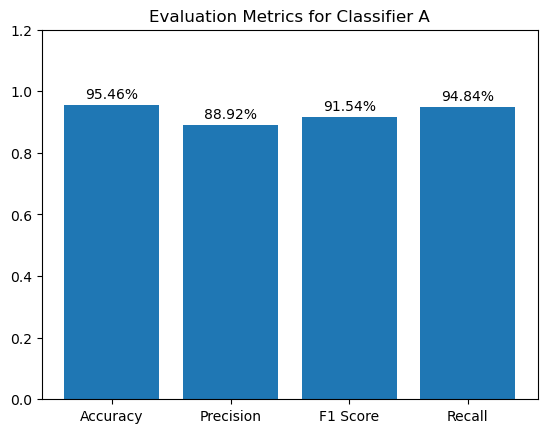

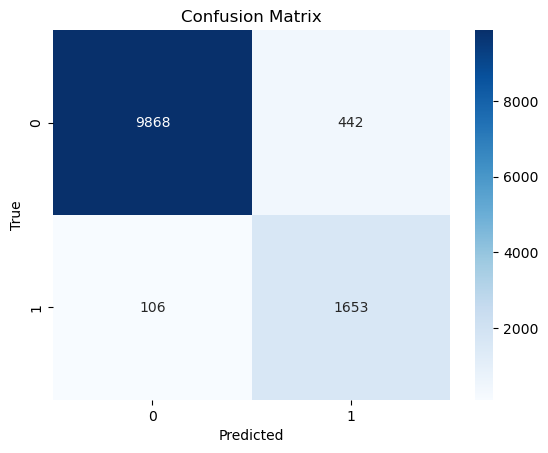

Accuracy: 0.9545944154445273, Precision: 0.8891969239354063, F1 Score: 0.9153968499410089, Recall: 0.9484337443735391
Saving the model


C:\Users\Anwender\AppData\Local\Temp\ipykernel_26600\242470676.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 354/354 [00:01<00:00, 199.90it/s]


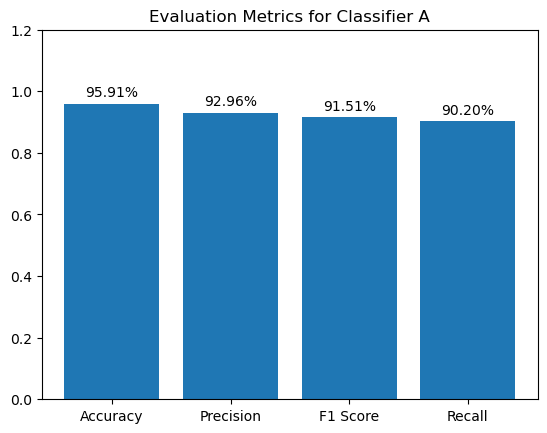

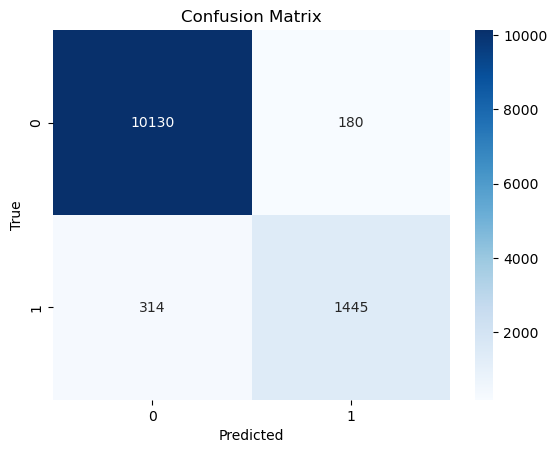

Accuracy: 0.9590686883751761, Precision: 0.9295828300385942, F1 Score: 0.9151081360373494, Recall: 0.9020153523875273
Saving the model


C:\Users\Anwender\AppData\Local\Temp\ipykernel_26600\242470676.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.tokenized_inputs.items()}
100%|██████████| 354/354 [00:01<00:00, 206.52it/s]


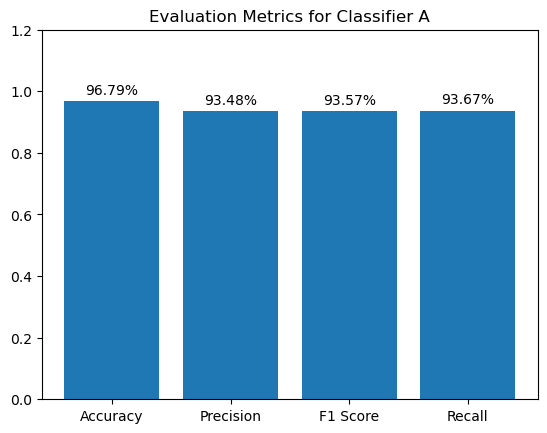

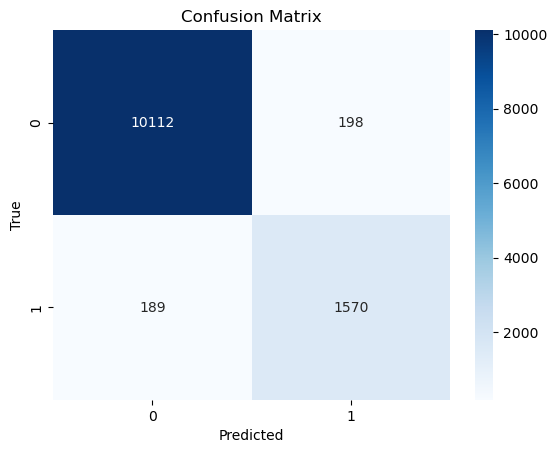

Accuracy: 0.9679343773303505, Precision: 0.9348306582719861, F1 Score: 0.9357493198603475, Recall: 0.936673965511442
Saving the model


In [9]:
# train the model
trained_model_A = train_classifier_A(train_df, valid_df)